# Chapter 5 - Pretraining on unlabeled data

In [112]:
import torch
from gpt import GPTModel

In [113]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [114]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_block): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_ptoj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=

In [115]:
# idx is a (batch_size, n_tokens) array of indices in the current context
def generate_text_sample(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        """
        crops current context if it exceeds the supported context size
        eg: if LLM supports only 5 tokens and the context size is 10
        only 5 tokens are used as context
        """
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        """
        Focuses only on the last time step so that (batch_size, n_tokens, vocab_size)
        becomes (batch_size, vocab_size)
        """
        logits = logits[:,-1,:]
        # probas has shape (batch_size, vocab_size)
        probas = torch.softmax(logits, dim=-1)
        # idx_next has shape (batch_size, 1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        """
        Append sampled index tot he running sequence
        where idx has shape (batch, n_tokens+1)
        """
        idx = torch.cat((idx, idx_next), dim=-1)
    return idx

In [116]:
import tiktoken

In [117]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

In [118]:
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [119]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_sample(
    model = model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print(f"Output text:\n {token_ids_to_text(token_ids, tokenizer)}")

Output text:
 Every effort moves you rentingetic wasnم refres RexAngel214nesiumfigured


Text evaluation example

In [120]:
inputs = torch.tensor([[16833,3626,6100],       #every effor moves
                       [40,1107,588]])          #I really like

In [121]:
targets = torch.tensor([[3626,6100,345],        #effort moves you
                        [1107,588,11311]])      #really like chocolate

In [122]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [123]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(f"Token Ids: {token_ids}")

Token Ids: tensor([[[16657],
         [16031],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [124]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Output batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Output batch 1:  Armed savesNetflix


In [125]:
probas

tensor([[[1.9576e-05, 1.5754e-05, 1.1587e-05,  ..., 2.1908e-05,
          7.0255e-06, 1.8478e-05],
         [9.4945e-06, 1.0247e-05, 7.7444e-06,  ..., 2.8397e-05,
          6.1837e-06, 1.2869e-05],
         [2.8746e-05, 8.5582e-06, 1.5153e-05,  ..., 3.7397e-05,
          1.3669e-05, 1.2614e-05]],

        [[1.2261e-05, 2.0023e-05, 1.3299e-05,  ..., 1.0177e-05,
          3.5075e-05, 1.3706e-05],
         [7.4842e-06, 1.7175e-05, 1.0332e-05,  ..., 2.1160e-05,
          1.1552e-05, 1.4645e-05],
         [2.8896e-05, 3.3004e-05, 4.2034e-05,  ..., 6.6369e-06,
          5.7847e-05, 1.3099e-05]]])

In [126]:
text_ids = 0
target_probas_1 = probas[text_ids, [0,1,2], targets[text_ids]]
print("Text 1:", target_probas_1)


Text 1: tensor([7.1165e-05, 3.1117e-05, 1.1661e-05])


In [127]:
text_ids = 1
target_probas_2 = probas[text_ids, [0,1,2], targets[text_ids]]
print("Text 2:",target_probas_2)

Text 2: tensor([1.0360e-05, 5.3230e-05, 4.7808e-06])


In [128]:
log_probas = torch.log(torch.cat((target_probas_1,target_probas_2)))
print(log_probas)

tensor([ -9.5505, -10.3778, -11.3593, -11.4776,  -9.8409, -12.2509])


In [129]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.8095)


In [130]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.8095)


All this can be done via a single function in pytorch

In [131]:
print(f"Logits shape:{logits.shape}")
print(f"Targets shape: {targets.shape}")

Logits shape:torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


combine batch size and number of tokens

In [132]:
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()
print(f"Flattened logits: {logits_flat.shape}")
print(f"Flatteneed targets: {targets_flat.shape}")

Flattened logits: torch.Size([6, 50257])
Flatteneed targets: torch.Size([6])


In [133]:
loss = torch.nn.functional.cross_entropy(logits_flat,targets_flat)
print(loss)

tensor(10.8095)


In [134]:
preplexity = torch.exp(loss)
print(preplexity)

tensor(49487.9023)


Load the verdict dataset

In [135]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [136]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(f"Total characters: {total_characters}")
print(f"Total tokens: {total_tokens}")

Total characters: 20479
Total tokens: 5145


In [137]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
test_data = text_data[split_idx:]

In [138]:
from dataloader import create_dataloader_v1

torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
test_loader = create_dataloader_v1(
    test_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

verify created data loaders

In [139]:
print(f"Train loaders:")
for x, y in train_loader:
    print(x.shape, y.shape)

print(f"Validation Loader")
for x, y in test_loader:
    print(x.shape, y.shape)

Train loaders:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Validation Loader
torch.Size([2, 256]) torch.Size([2, 256])


cross entropy loss for batch

In [140]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )
    return loss

In [141]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i,(input_batch, target_batch) in enumerate(data_loader):
        if i<num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches


In [142]:
device = torch.device("cude" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device
        )
    val_loss = calc_loss_loader(
        test_loader, model, device
    )
print(f"Training loss: {train_loss}")
print(f"val_loss: {val_loss}")


Training loss: 10.986397849188911
val_loss: 10.980345726013184


In [145]:
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                      )
                
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [146]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss


In [153]:
def generate_and_print_sample( model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_sample(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace('\n',' '))
    model.train()

In [154]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, test_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (step 000000): Train loss 9.753, Val loss 9.884
Ep 1 (step 000005): Train loss 8.118, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (step 000010): Train loss 6.675, Val loss 7.051
Ep 2 (step 000015): Train loss 5.997, Val loss 6.629
Every effort moves you, and,, and,,,,,,, and,,,,,,,,,,,,,,,, and,,,, and,,,,,,,, and,,,,,,
Ep 3 (step 000020): Train loss 5.746, Val loss 6.500
Ep 3 (step 000025): Train loss 5.546, Val loss 6.433
Every effort moves you, and, and I had to the to the, and I had to the of the--I, and, and I had to to the the of the the of the, and I had to the of the of the of the to the of
Ep 4 (step 000030): Train loss 4.792, Val loss 6.393
Ep 4 (step 000035): Train loss 4.382, Val loss 6.276
Every effort moves you know the picture.    "--and it a of the of the of the picture to me.     "I it--and it to the picture to the picture to the of the picture of the of the of
Ep 5 (step 000040): Train loss 3.822, Val loss 6.208
Ev

In [157]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens sees")
    fig.tight_layout()
    plt.show()

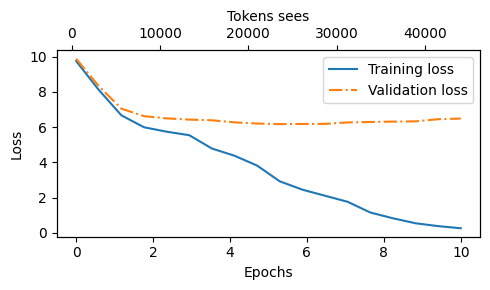

In [158]:
epoch_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epoch_tensor, tokens_seen, train_losses, val_losses)